In [1]:
# Hedging the option.


In [2]:
import math as mt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

class anoption:
    def __init__(self,T,K,sigma,r,call=True):
        self.T = T
        self.K = K
        self.call = call
        self.sigma = sigma
        self.r = r
    def price(self,t,S):
        tau = self.T.toordinal()-t.toordinal()
        tau = tau/365.0
        sigma = self.sigma
        r = self.r
        K = self.K
        ss = sigma*mt.sqrt(tau)
        d1 = 1/ss*(mt.log(S/K)+(r+sigma**2/2)*tau)
        d2 = d1 - ss
        self.d1 = d1
        self.d2 = d2
        PVK = K*mt.exp(-r*tau) #strike price
        if self.call:
            delta = st.norm.cdf(d1)
            self.delta = delta
            prob1 = delta
            prob2 = st.norm.cdf(d2)
            val2ret = prob1*S - prob2*PVK
        else:
            delta = st.norm.cdf(-d1)
            self.delta = -delta
            prob1 = st.norm.cdf(-d2)
            prob2 = delta
            val2ret = prob1*PVK - prob2*S
        self.value = val2ret
        return val2ret
        
class underlying:
    def __init__(self,S0,t0,mu,sigma):
        self.S0 = S0
        self.t0 = t0
        self.mu = mu
        self.sigma = sigma
    def getret(self):
        ret = np.random.normal(self.mu/365,self.sigma/mt.sqrt(365),1)
        return float(ret)
    
class anaccount:
    def __init__(self,r,und,opt,n_options,sfee,cash0):
        self.r = r
        self.und = und
        self.opt = opt
        self.n_options = n_options
        self.fee_rate = sfee
        self.cash0 = cash0
        self.records = pd.DataFrame(columns=['Stk Prc','Opt Prc','Stk N','Opt N','Stk Pos','Opt Pos','Cash no hedge','Total no hedge','Cash','Total'])
        self.addrecord()
    def addrecord(self): 
        nr, nc = np.shape(self.records)
        if nr == 0: 
            newdate = self.und.t0
            newprce = self.und.S0
        else:
            vakar = self.records.iloc[-1,]
            yesterday = vakar.name
            newdate = pd.Timestamp(1989,6,24)
            newdate = newdate.fromordinal(yesterday.toordinal()+1)
            yesterday_price = vakar['Stk Prc']
            newprce = yesterday_price*(1+self.und.getret())
        optval = self.opt.price(newdate,newprce)
        optN = self.n_options
        stkN = -self.opt.delta*optN
        optpos = optN*optval
        stkpos = stkN*newprce
        if nr == 0:
            cash_nh = self.cash0 - optpos
            cash = cash_nh - stkpos
            if optpos < 0:
                thefee = -optpos*self.fee_rate
                cash = cash + thefee
                cash_nh = cash_nh + thefee
                price_to_quote = -optpos+thefee
        else:
            yesterday_stkN = vakar['Stk N']
            stk2buy = (stkN - yesterday_stkN)*newprce
            cash = vakar.Cash - stk2buy
            cash_nh = vakar['Cash no hedge']
        total = optpos+stkpos+cash
        total_nh = optpos+cash_nh
        newrow = pd.Series(
            {'Stk Prc':newprce,
             'Opt Prc':optval,
             'Stk N':stkN,
             'Opt N':optN,
             'Stk Pos':stkpos,
             'Opt Pos':optpos,
             'Cash':cash,
             'Total':total,
             'Cash no hedge':cash_nh,
             'Total no hedge':total_nh},name = newdate)
        self.records = self.records.append(newrow)
    def simulate(self,ndays,nruns):
        mintotal = 10**25
        for arun in range(nruns):
            self.records = pd.DataFrame(columns=['Stk Prc','Opt Prc','Stk N','Opt N','Stk Pos','Opt Pos','Cash no hedge','Total no hedge','Cash','Total'])
            self.addrecord()          
            for i in range(ndays): self.addrecord()
            thismin = min(self.records.Total)
            mintotal = min(mintotal,thismin)
        return(mintotal)
        

In [15]:
r = 0.05
sigma = 0.3
K = 50
mu = 0.5
T = pd.Timestamp(2019,8,31)
put1 = anoption(T,K,sigma,r,False)
today = pd.Timestamp(2019,5,27)
stk1 = underlying(K,today,mu,sigma)
acc1 = anaccount(r,stk1,put1,-1,0.1,100)
print([r, sigma, K, mu])

[0.9, 0.3, 50, 0.5]


In [16]:
acc1.simulate(30,100)

98.91911175017019

In [17]:
acc1.records

,Stk Prc,Opt Prc,Stk N,Opt N,Stk Pos,Opt Pos,Cash no hedge,Total no hedge,Cash,Total
2019-05-27,50.000000,0.182936,-0.053104,-1.0,-2.655207,-0.182936,100.20123,100.018294,102.856436,100.018294
2019-05-28,50.373419,0.166416,-0.048896,-1.0,-2.463064,-0.166416,100.20123,100.034814,102.644463,100.014984
2019-05-29,51.573570,0.117902,-0.035766,-1.0,-1.844569,-0.117902,100.20123,100.083327,101.967285,100.004815
2019-05-30,53.207575,0.071984,-0.022716,-1.0,-1.208668,-0.071984,100.20123,100.129245,101.272943,99.992291
2019-05-31,54.421484,0.049329,-0.016014,-1.0,-0.871511,-0.049329,100.20123,100.151901,100.908211,99.987371
2019-06-01,56.030218,0.029249,-0.009824,-1.0,-0.550439,-0.029249,100.20123,100.171980,100.561377,99.981688
2019-06-02,55.559947,0.034510,-0.011544,-1.0,-0.641393,-0.034510,100.20123,100.166719,100.656950,99.981047
2019-06-03,56.275546,0.027309,-0.009296,-1.0,-0.523141,-0.027309,100.20123,100.173920,100.530437,99.979987
2019-06-04,56.221688,0.028005,-0.009568,-1.0,-0.537932,-0.028005,100.20123,100.173225,100.545730,99.979793
2019-06-05,56.477986,0.025812,-0.008902,-1.0,-0.502763,-0.025812,100.20123,100.175417,100.508108,99.979533


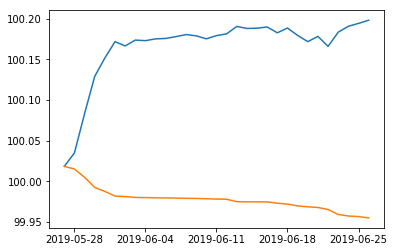

In [18]:
plt.plot(acc1.records['Total no hedge'])
plt.plot(acc1.records['Total'])

In [21]:
np.random.RandomState(np.random.seed(2019))
r = np.random.uniform(0.0, 0.1)
sigma = np.random.uniform(0.0, 1.0)
K = 50
mu = np.random.uniform(0.0, 1.0)
T = pd.Timestamp(2019,8,31)
put1 = anoption(T,K,sigma,r,True)
today = pd.Timestamp(2019,5,27)
stk1 = underlying(K,today,mu,sigma)
acc1 = anaccount(r,stk1,put1,-1,0.1,100)
print([r, sigma, K, mu])

[0.09034822144192745, 0.3930805066502425, 50, 0.6239699612977534]


In [22]:
acc1.simulate(30,100)

100.07270705171503

In [23]:
acc1.records

,Stk Prc,Opt Prc,Stk N,Opt N,Stk Pos,Opt Pos,Cash no hedge,Total no hedge,Cash,Total
2019-05-27,50.000000,4.581725,0.586547,-1.0,29.327359,-4.581725,105.039898,100.458173,75.712538,100.458173
2019-05-28,49.045212,4.013427,0.548308,-1.0,26.891859,-4.013427,105.039898,101.026471,77.588010,100.466442
2019-05-29,48.798203,3.853172,0.537611,-1.0,26.234459,-3.853172,105.039898,101.186725,78.109974,100.491260
2019-05-30,49.108527,3.995592,0.549563,-1.0,26.988247,-3.995592,105.039898,101.044306,77.523019,100.515674
2019-05-31,48.066876,3.419734,0.505692,-1.0,24.307033,-3.419734,105.039898,101.620164,79.631779,100.519079
2019-06-01,48.382005,3.555113,0.518066,-1.0,25.065083,-3.555113,105.039898,101.484785,79.033088,100.543058
2019-06-02,47.048228,2.876974,0.460165,-1.0,21.649926,-2.876974,105.039898,102.162923,81.757260,100.530212
2019-06-03,47.569625,3.097243,0.481589,-1.0,22.909031,-3.097243,105.039898,101.942654,80.738083,100.549871
2019-06-04,46.359388,2.521989,0.427663,-1.0,19.826217,-2.521989,105.039898,102.517909,83.238061,100.542289
2019-06-05,47.058587,2.806557,0.457093,-1.0,21.510149,-2.806557,105.039898,102.233341,81.853150,100.556742


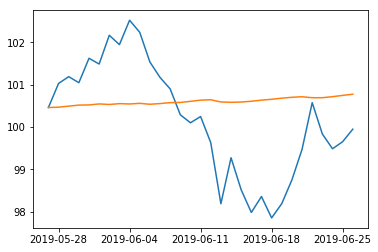

In [24]:
plt.plot(acc1.records['Total no hedge'])
plt.plot(acc1.records['Total'])

In [11]:
# Do the same using futures.

In [25]:
import math as mt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot

class anoption:
    def __init__(self,T,K,sigma,r,call=True):
        self.T = T
        self.K = K
        self.call = call
        self.sigma = sigma
        self.r = r
    def price(self,t,S):
        tau = self.T.toordinal()-t.toordinal()
        tau = tau/365.0
        sigma = self.sigma
        r = self.r
        K = self.K
        ss = sigma*mt.sqrt(tau)
        d1 = 1/ss*(mt.log(S/K)+(r+sigma**2/2)*tau)
        d2 = d1 - ss
        self.d1 = d1
        self.d2 = d2
        PVK = K*mt.exp(-r*tau)
        if self.call:
            delta = st.norm.cdf(d1)
            self.delta = delta
            prob1 = delta
            prob2 = st.norm.cdf(d2)
            val2ret = prob1*S - prob2*PVK
        else:
            delta = st.norm.cdf(-d1)
            self.delta = -delta
            prob1 = st.norm.cdf(-d2)
            prob2 = delta
            val2ret = prob1*PVK - prob2*S 
        self.value = val2ret
        return val2ret
        
class underlying:
    def __init__(self,S0,t0,mu,sigma):
        self.S0 = S0
        self.t0 = t0
        self.mu = mu
        self.sigma = sigma
    def getret(self):
        ret = np.random.normal(self.mu/365,self.sigma/mt.sqrt(365),1)
        return float(ret)

class futures:
    def __init__(self,T,r):
        self.T = T
        self.r = r
    def price(self,t,S):
        tau = self.T.toordinal()-t.toordinal()
        tau = tau/365.0
        self.delta = mt.exp(self.r*tau)
        self.F = S*self.delta
        return(self.F)
    
class anaccount:
    def __init__(self,r,und,opt,fut,n_options,sfee,cash0):
        self.r = r
        self.und = und
        self.opt = opt
        self.fut = fut
        self.n_options = n_options
        self.fee_rate = sfee
        self.cash0 = cash0
        self.records = pd.DataFrame(columns=['Stk Prc','Fut Prc','Opt Prc','Fut N','Opt N','Fut Pos','Opt Pos','Cash no hedge','Total no hedge','Cash','Total'])
        self.addrecord()
    def addrecord(self): 
        nr, nc = np.shape(self.records)
        if nr == 0: 
            newdate = self.und.t0
            newprce = self.und.S0
        else:
            vakar = self.records.iloc[-1,]
            yesterday = vakar.name
            newdate = pd.Timestamp(1989,6,24)
            newdate = newdate.fromordinal(yesterday.toordinal()+1)
            yesterday_price = vakar['Stk Prc']
            newprce = yesterday_price*(1+self.und.getret())
        optval = self.opt.price(newdate,newprce)
        optN = self.n_options
        futprc = self.fut.price(newdate,newprce)
        futN = -self.opt.delta/self.fut.delta*optN
        optpos = optN*optval
        futpos = futN*futprc
        if nr == 0:
            cash_nh = self.cash0 - optpos
            cash = cash_nh
            if optpos < 0:
                thefee = -optpos*self.fee_rate
                cash = cash + thefee
                cash_nh = cash_nh + thefee
                price_to_quote = -optpos+thefee
        else:
   #         yesterday_stkN = vakar['Stk N']
   #         stk2buy = (stkN - yesterday_stkN)*newprce
            yesterday_F = vakar['Fut Prc']
            cash2add = (futprc-yesterday_F)*futpos
            cash = vakar.Cash + cash2add
            cash_nh = vakar['Cash no hedge']
        total = optpos+cash
        total_nh = optpos+cash_nh
        newrow = pd.Series(
            {'Stk Prc':newprce,
             'Fut Prc':futprc,
             'Opt Prc':optval,
             'Fut N':futN,
             'Opt N':optN,
             'Fut Pos':futpos,
             'Opt Pos':optpos,
             'Cash':cash,
             'Total':total,
             'Cash no hedge':cash_nh,
             'Total no hedge':total_nh},name = newdate)
        self.records = self.records.append(newrow)
    def simulate(self,ndays,nruns):
        mintotal = 10**25
        for arun in range(nruns):
            self.records = pd.DataFrame(columns=['Stk Prc','Opt Prc','Stk N','Opt N','Stk Pos','Opt Pos','Cash no hedge','Total no hedge','Cash','Total'])
            self.addrecord()          
            for i in range(ndays): self.addrecord()
            thismin = min(self.records.Total)
            mintotal = min(mintotal,thismin)
        return(mintotal)
        

IndentationError: expected an indented block (<ipython-input-25-00aa0f518486>, line 54)

In [16]:
# Scratch work

<h3> Scratch work </h3>